<a href="https://colab.research.google.com/github/Arbi7k/Data-Science-Fundamentals/blob/main/Half_semester_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Read tutorial in full before starting anything & answer questions and document the important steps of the process (10 pts)
The tutorial you will follow is below, however we will NOT use their training set.
https://projects.volkamerlab.org/teachopencadd/talktorials/
T022_ligand_based_screening_neural_network.html
The dataset for kinases can be found here (you might need to prepare or alter it):
https://cloud-new.gdb.tools/index.php/s/ZfZM7itQf3rm6Sw
1. What is in the training set, how big is it?
2. What modifications do you need to do to the data set to perform the tutorial.
3. What is a test set? Any other types of set?
4. Before starting describe with 1-2 sentences, in your own words, what is done in each
of the cells.

#### Perform the tutorial on either your computer or google colab (10 pts)
Document with screenshots or notebook to get the points.

In [1]:
from pathlib import Path
from warnings import filterwarnings

# Silence some expected warnings
filterwarnings("ignore")

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw, rdFingerprintGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns

# Neural network specific libraries
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline

ModuleNotFoundError: No module named 'rdkit'

In [2]:
# Set path to this notebook
HERE = Path(_dh[-1])
DATA = HERE / "data"

In [7]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Set path to the CSV file
path = '/content/drive/My Drive/kinase.csv'

# Load data
df = pd.read_csv(DATA / path, index_col=0)
df = df.reset_index(drop=True)

# Check the dimension and missing value of the data
print("Shape of dataframe : ", df.shape)
df.info()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Shape of dataframe :  (179827, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179827 entries, 0 to 179826
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   molecule_chembl_id  179827 non-null  object 
 1   standard_value      179827 non-null  float64
 2   standard_units      179827 non-null  object 
 3   target_chembl_id    179827 non-null  object 
 4   smiles              179827 non-null  object 
dtypes: float64(1), object(4)
memory usage: 6.9+ MB


In [8]:
# Look at head
df.head()
# NBVAL_CHECK_OUTPUT

,molecule_chembl_id,standard_value,standard_units,target_chembl_id,smiles
0,CHEMBL13462,4000.0,nM,CHEMBL1862,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
1,CHEMBL13462,16000.0,nM,CHEMBL1862,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
2,CHEMBL13462,800.0,nM,CHEMBL267,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
3,CHEMBL13462,9000.0,nM,CHEMBL267,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
4,CHEMBL13462,1700.0,nM,CHEMBL267,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...


In [10]:
# Keep necessary columns
chembl_df = df[["standard_value", "target_chembl_id", "smiles"]]
chembl_df.head()
# NBVAL_CHECK_OUTPUT

,standard_value,target_chembl_id,smiles
0,4000.0,CHEMBL1862,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
1,16000.0,CHEMBL1862,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
2,800.0,CHEMBL267,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
3,9000.0,CHEMBL267,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...
4,1700.0,CHEMBL267,CC(=O)N[C@@H](Cc1ccc(OP(=O)(O)O)cc1)C(=O)N[C@@...


In [11]:
def smiles_to_fp(smiles, method="maccs", n_bits=2048):
    """
    Encode a molecule from a SMILES string into a fingerprint.

    Parameters
    ----------
    smiles : str
        The SMILES string defining the molecule.

    method : str
        The type of fingerprint to use. Default is MACCS keys.

    n_bits : int
        The length of the fingerprint.

    Returns
    -------
    array
        The fingerprint array.
    """

    # Convert smiles to RDKit mol object
    mol = Chem.MolFromSmiles(smiles)

    if method == "maccs":
        return np.array(MACCSkeys.GenMACCSKeys(mol))
    if method == "morgan2":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
        return np.array(fpg.GetCountFingerprint(mol))
    if method == "morgan3":
        fpg = rdFingerprintGenerator.GetMorganGenerator(radius=3, fpSize=n_bits)
        return np.array(fpg.GetCountFingerprint(mol))
    else:
        print(f"Warning: Wrong method specified: {method}." " Default will be used instead.")
        return np.array(MACCSkeys.GenMACCSKeys(mol))

In [12]:
chembl_df["fingerprints_df"] = chembl_df["canonical_smiles"].apply(smiles_to_fp)

# Look at head
print("Shape of dataframe:", chembl_df.shape)
chembl_df.head(3)
# NBVAL_CHECK_OUTPUT

KeyError: 'canonical_smiles'

In [13]:
# Split the data into training and test set
x_train, x_test, y_train, y_test = train_test_split(
    chembl_df["fingerprints_df"], chembl_df[["pIC50"]], test_size=0.3, random_state=42
)

# Print the shape of training and testing data
print("Shape of training data:", x_train.shape)
print("Shape of test data:", x_test.shape)
# NBVAL_CHECK_OUTPUT

NameError: name 'train_test_split' is not defined

In [14]:
def neural_network_model(hidden1, hidden2):
    """
    Creating a neural network from two hidden layers
    using ReLU as activation function in the two hidden layers
    and a linear activation in the output layer.

    Parameters
    ----------
    hidden1 : int
        Number of neurons in first hidden layer.

    hidden2: int
        Number of neurons in second hidden layer.

    Returns
    -------
    model
        Fully connected neural network model with two hidden layers.
    """

    model = Sequential()
    # First hidden layer
    model.add(Dense(hidden1, activation="relu", name="layer1"))
    # Second hidden layer
    model.add(Dense(hidden2, activation="relu", name="layer2"))
    # Output layer
    model.add(Dense(1, activation="linear", name="layer3"))

    # Compile model
    model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse", "mae"])
    return model

In [15]:
# Neural network parameters
batch_sizes = [16, 32, 64]
nb_epoch = 50
layer1_size = 64
layer2_size = 32

In [16]:
# Plot
fig = plt.figure(figsize=(12, 6))
sns.set(color_codes=True)
for index, batch in enumerate(batch_sizes):
    fig.add_subplot(1, len(batch_sizes), index + 1)
    model = neural_network_model(layer1_size, layer2_size)

    # Fit model on x_train, y_train data
    history = model.fit(
        np.array(list((x_train))).astype(float),
        y_train.values,
        batch_size=batch,
        validation_data=(np.array(list((x_test))).astype(float), y_test.values),
        verbose=0,
        epochs=nb_epoch,
    )
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="test")
    plt.legend(["train", "test"], loc="upper right")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.ylim((0, 15))
    plt.title(
        f"test loss = {history.history['val_loss'][nb_epoch-1]:.2f}, " f"batch size = {batch}"
    )
plt.show()

NameError: name 'sns' is not defined

<Figure size 1200x600 with 0 Axes>

In [17]:
# Save the trained model
filepath = DATA / "best_weights.hdf5"
checkpoint = ModelCheckpoint(
    str(filepath),
    monitor="loss",
    verbose=0,
    save_best_only=True,
    mode="min",
    save_weights_only=True,
)
callbacks_list = [checkpoint]

# Fit the model
model.fit(
    np.array(list((x_train))).astype(float),
    y_train.values,
    epochs=nb_epoch,
    batch_size=16,
    callbacks=callbacks_list,
    verbose=0,
)

NameError: name 'ModelCheckpoint' is not defined

In [18]:
# Evalute the model
print(f"Evaluate the model on the test data")
scores = model.evaluate(np.array(list((x_test))), y_test.values, verbose=0)
print(f" loss: {scores[0]:.2f}")
print(f" mse (same as loss): {scores[1]:.2f}")
print(f" mae: {scores[2]:.2f}")

Evaluate the model on the test data


NameError: name 'model' is not defined

In [19]:
# Predict pIC50 values on x_test data
y_pred = model.predict(np.array(list((x_test))))

# Print 5 first pIC50 predicted values
first_5_prediction = [print(f"{value[0]:.2f}") for value in y_pred[0:5]]

NameError: name 'model' is not defined

NameError: name 'y_pred' is not defined

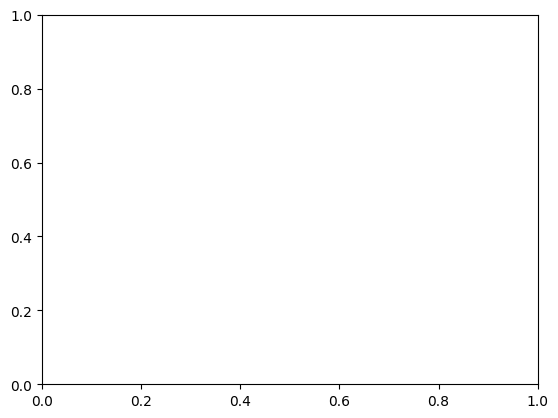

In [20]:
# Scatter plot
limits = 0, 15
fig, ax = plt.subplots()
ax.scatter(y_pred, y_test, marker=".")
lin = np.linspace(*limits, 100)
ax.plot(lin, lin)
ax.set_aspect("equal", adjustable="box")
ax.set_xlabel("Predicted values")
ax.set_ylabel("True values")
ax.set_title("Scatter plot: pIC50 values")
ax.set_xlim(limits)
ax.set_ylim(limits)
plt.show()

In [21]:
# Load external/unlabeled data set
external_data = pd.read_csv(DATA / "test.csv", index_col=0)
external_data = external_data.reset_index(drop=True)
external_data.head()
# NBVAL_CHECK_OUTPUT

FileNotFoundError: [Errno 2] No such file or directory: '/content/data/test.csv'

In [22]:
# Load model
model = load_model(DATA / "ANN_model.hdf5", compile=False)

NameError: name 'load_model' is not defined

In [23]:
# Prediction on external/unlabeled data
predictions = model.predict(
    np.array(list((external_data["fingerprints_df"]))).astype(float), callbacks=callbacks_list
)

predicted_pIC50 = pd.DataFrame(predictions, columns=["predicted_pIC50"])
predicted_pIC50_df = external_data.join(predicted_pIC50)

predicted_pIC50_df.head(3)

NameError: name 'model' is not defined

In [24]:
# Save the predicted values in a csv file in the data folder
predicted_pIC50_df.to_csv(DATA / "predicted_pIC50_df.csv")

NameError: name 'predicted_pIC50_df' is not defined

In [25]:
# Select top 3 drugs
predicted_pIC50_df = pd.read_csv(DATA / "predicted_pIC50_df.csv", index_col=0)
top3_drug = predicted_pIC50_df.nlargest(3, "predicted_pIC50")
top3_drug

FileNotFoundError: [Errno 2] No such file or directory: '/content/data/predicted_pIC50_df.csv'

In [26]:
# Draw the drug molecules
highest_pIC50 = predicted_pIC50_df["canonical_smiles"][top3_drug.index]

mols_EGFR = [Chem.MolFromSmiles(smile) for smile in highest_pIC50]
pIC50_EGFR = top3_drug["predicted_pIC50"].tolist()
pIC50_values = [(f"pIC50 value: {value:.2f}") for value in pIC50_EGFR]

Draw.MolsToGridImage(mols_EGFR, molsPerRow=3, subImgSize=(450, 300), legends=pIC50_values)

NameError: name 'predicted_pIC50_df' is not defined